In [1]:
import math
import torch
import numpy as np
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED=3407
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [2]:
from imputation_model import *
from train import *
from utils import *
from losses import *

In [3]:
import scanpy as sc
from scipy import sparse

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
def e2eImpute(adata,
              project='AE',
              imputation='GAE',
              k=3,
              distance='hyperbolic',
              z_dim=64,
              y_dim=128,
              pro_dim1=128,
              pro_dim2=1024,
              use_raw=True,
              no_cuda=False,
              epochs=1000,
              lr=0.001,
              weight_decay=0.0005,
              patience=200,
              alpha=0.1,
              beta=0.9,
              gamma=0.5,
              fastmode=False,
              verbose=True):
    
    adata = adata.copy()
    #adata = normalize(adata, filter_min_counts=False)
    
    true_values=torch.tensor(adata.raw.X.A, dtype=torch.float).to(device)
    size_factors = 1.0
    
    data=torch.tensor(adata.X.toarray(), dtype=torch.float).to(device)
    model=IntegratedModel(data,size_factors=size_factors, project=project, imputation=imputation, k=k, distance=distance,
                         z_dim=z_dim, y_dim=y_dim, pro_dim1=pro_dim1, pro_dim2=pro_dim2, use_raw=use_raw).to(device)
    
    print(model)

    train(data=data, true_values=true_values, model=model,
          project=project, imputation=imputation, no_cuda=no_cuda, epochs=epochs, lr=lr, weight_decay=weight_decay,
          patience=patience, alpha=alpha, beta=beta,gamma=gamma, fastmode=fastmode, verbose=verbose)

    
    if project == 'AE' and imputation == 'GAE':
        output_mlp, pred = model(data)
        result = pred.detach().cpu()
    if project == 'AE' and imputation == 'ZINBGAE':
        output_mlp, pred, z_mean, z_dropout, z_dispersion = model(data)
        result = pred.detach().cpu()
    if project == 'ZINBAE' and imputation == 'GAE':
        output_mlp, _, _, _, pred = model(data)
        result = pred.detach().cpu()
    if project == 'ZINBAE' and imputation == 'ZINBGAE':
        output_mlp, _, _, _, pred, _, _, _ = model(data)
        result = pred.detach().cpu()

    return result

In [5]:
def pearsonr_error(y, h):
    res = []
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))

    for i in range(y.shape[0]):
        res.append(pearsonr(y[i], h[i])[0])
    return np.mean(res)


def cosine_similarity_score(y, h):
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))
    cos = cosine_similarity(y, h)
    res = []
    for i in range(len(cos)):
        res.append(cos[i][i])
    return np.mean(res)

In [1101]:
adata = sc.read_h5ad('./data/Zeisel_top2000/masked/Zeisel_top2000_00.h5ad')

D:\Anaconda3\envs\PyTorch\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [1261]:
%%time
result = e2eImpute(adata=adata,
                    project='ZINBAE', #AE ZINBAE
                    imputation='GAE', #GAE ZINBGAE
                    k=1,
                    distance='hyperbolic', #euclidean, manhattan, hyperbolic, cosine
                    z_dim=128,
                    y_dim=1024,
                    pro_dim1=128,
                    pro_dim2=1024,
                    use_raw=True,
                    no_cuda=False,
                    epochs=25000,
                    lr=0.003, 
                    weight_decay=0,
                    patience=20,
                    alpha=0.0001,
                    beta=1,
                    gamma=0.9999,
                    fastmode=False,
                    verbose=True)

D:\Anaconda3\envs\PyTorch\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


IntegratedModel(
  (mlp): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=2001, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=128, out_features=2001, bias=True)
    )
  )
  (zinbae): ZINBAE(
    (enc1): Linear(in_features=2001, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dr1): Dropout(p=0.2, inplace=False)
    (mean_act): MeanAct()
    (disp_act): DispAct()
    (pi_act): Sigmoid()
    (dense2_mean): Linear(in_features=128, out_features=2001, bias=True)
    (dense2_disp): Linear(in_features=128, out_features=2001, bias=True)
    (dense2_pi): Linear(in_features=128, out_features=2001, bias=True)
    (dec1): Linear(in_features=2001, out_features=1024, bias=True)
    (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dr2): Dropout(p=0.4, inplace=False)
    (dec2): Linear(in_features=1024, out_features=20

Epoch: 2060 loss_train: 2.3953
Epoch: 2070 loss_train: 2.3940
Epoch: 2080 loss_train: 2.3840
Epoch: 2090 loss_train: 2.3785
Epoch: 2100 loss_train: 2.3762
Epoch: 2110 loss_train: 2.3679
Epoch: 2120 loss_train: 2.3775
Epoch: 2130 loss_train: 2.3662
Epoch: 2140 loss_train: 2.3565
Epoch: 2150 loss_train: 2.3535
Epoch: 2160 loss_train: 2.3677
Epoch: 2170 loss_train: 2.3465
Epoch: 2180 loss_train: 2.3373
Epoch: 2190 loss_train: 2.3346
Epoch: 2200 loss_train: 2.3639
Epoch: 2210 loss_train: 2.3351
Epoch: 2220 loss_train: 2.3255
Epoch: 2230 loss_train: 2.3204
Epoch: 2240 loss_train: 2.3178
Epoch: 2250 loss_train: 2.3099
Epoch: 2260 loss_train: 2.3268
Epoch: 2270 loss_train: 2.3099
Epoch: 2280 loss_train: 2.3028
Epoch: 2290 loss_train: 2.3022
Epoch: 2300 loss_train: 2.2978
Epoch: 2310 loss_train: 2.2909
Epoch: 2320 loss_train: 2.2861
Epoch: 2330 loss_train: 2.3050
Total time elapsed: 90.7728s
CPU times: total: 1min 31s
Wall time: 1min 30s


##### Metrics calculation

In [1262]:
mse = float('%.4f' % mean_squared_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
mae = float('%.4f' % mean_absolute_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
pcc = float('%.4f' % pearsonr_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
cs = float('%.4f' % cosine_similarity_score(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))

In [1263]:
print(mse,mae,pcc,cs)

0.0 0.0 1.0 1.0


In [1264]:
mse = float('%.4f' % mean_squared_error(adata.raw.X.A, result))
mae = float('%.4f' % mean_absolute_error(adata.raw.X.A, result))
pcc = float('%.4f' % pearsonr_error(adata.raw.X.A, result))
cs = float('%.4f' % cosine_similarity_score(adata.raw.X.A, result))

In [1265]:
print(mse,mae,pcc,cs)

2.285 0.3834 0.9547 0.9559


In [1266]:
adata.obs

,cell_id,level1class,n_genes_by_counts,total_counts,label,n_genes,total_counts_mt,pct_counts_mt
cell_id,,,,,,,,
1772071015_C02,1772071015_C02,interneurons,4848,21580.0,interneurons,4848,0.0,0.0
1772071017_G12,1772071017_G12,interneurons,4684,21747.0,interneurons,4685,0.0,0.0
1772071017_A05,1772071017_A05,interneurons,6026,31640.0,interneurons,6028,0.0,0.0
1772071014_B06,1772071014_B06,interneurons,5824,32914.0,interneurons,5824,0.0,0.0
1772067065_H06,1772067065_H06,interneurons,4700,21528.0,interneurons,4701,0.0,0.0
...,...,...,...,...,...,...,...,...
1772067059_B04,1772067059_B04,endothelial-mural,2220,4584.0,endothelial-mural,2221,0.0,0.0
1772066097_D04,1772066097_D04,endothelial-mural,1428,2559.0,endothelial-mural,1428,0.0,0.0
1772063068_D01,1772063068_D01,endothelial-mural,1976,4014.0,endothelial-mural,1977,0.0,0.0


In [1267]:
clusters = adata.obs['label'].values #klein
#clusters = adata.obs.level1class.values #zeisel

In [1268]:
import copy
adata_pred = sc.AnnData(copy.deepcopy(result.cpu().numpy()))

In [1269]:
sc.pp.normalize_total(adata_pred)
sc.pp.log1p(adata_pred)
sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000)
adata_pred = adata_pred[:, adata_pred.var.highly_variable]
print(adata_pred.X.shape)
sc.pp.scale(adata_pred, max_value=10)

(3005, 2001)


D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:269: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(
D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [1279]:
%%time
random_seed = np.random.randint(0, 10000)  
print("The seed is:", random_seed)

kmeans = KMeans(n_clusters=len(set(clusters)), n_init=1, random_state=random_seed).fit(adata_pred.X)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))
print(ari,nmi)

The seed is: 671
0.8567 0.8165
CPU times: total: 281 ms
Wall time: 113 ms


In [1280]:
adata_pred.obs['label']=adata.obs['label'].values #klein

In [1281]:
adata_pred.obs

,label
0,interneurons
1,interneurons
2,interneurons
3,interneurons
4,interneurons
...,...
3000,endothelial-mural
3001,endothelial-mural
3002,endothelial-mural
3003,endothelial-mural


In [1282]:
sc.tl.pca(adata_pred, svd_solver='arpack')
sc.pp.neighbors(adata_pred, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_pred)

D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


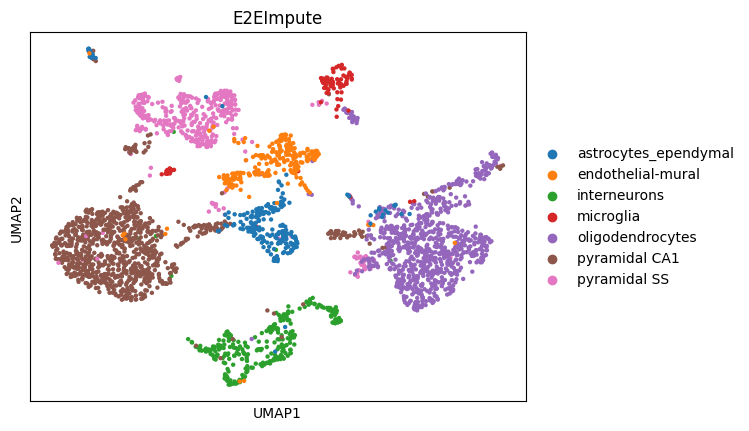

In [1283]:
sc.pl.umap(adata_pred, color=['label'], title='E2EImpute', frameon=True)

In [1188]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(adata_pred.obsm['X_umap'],kmeans.labels_)

In [1189]:
print("mse: ", mse)
print("mae: ", mae)
print("pcc: ", pcc)
print("cs: ", cs)
print("ari: ", ari)
print("nmi: ", nmi)
print("silhouette score: ", sil_score)

mse:  1.6796
mae:  0.3686
pcc:  0.9631
cs:  0.964
ari:  0.8565
nmi:  0.8187
silhouette score:  0.45445


### Save imputed data to disk

In [1098]:
result.cpu().numpy().shape, result.cpu().numpy().dtype

((3005, 2001), dtype('float32'))

In [1099]:
import scipy.io as sio
from scipy.sparse import csr_matrix 

In [1260]:
sio.mmwrite('./predicted_data/my_model/zeisel/zeisel00_top2000_e2eimpute.mtx',csr_matrix(result.cpu().numpy().T))